# Model 1 - Horizontal stratigraphic

I want to create 3-4 simple models in order to show the effect of the distance algorithm for Kriging and how it can be applied to Gempy models. In general I think 3 Layers should be fine, cutting out the central one. Keeping all in the same size around max 5000 grid points gives reasonable calculation times.
1) flat horizontal 
2) anticline 
3) recumbent anticline
4) layer pinching out ?
5) should be something like a fault

In [1]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Importing auxiliary libraries
import numpy as np
import matplotlib 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import pandas as pd

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
geo_data = gp.create_data([0,1000,0,20,0,1000],resolution=[100,2,100], 
                        path_o = "C:/Users/Jan/gempy/notebooks/prototype_notebooks/JanThesis/Jan_thesis_model1_orientations_slice.csv", path_i = "C:/Users/Jan/gempy/notebooks/prototype_notebooks/JanThesis/Jan_thesis_model1_interfaces_slice.csv")


In [3]:
gp.set_series(geo_data, {"Strat_Series": ('rock2','rock1'),"Basement_Series":('basement')},order_series = ['Strat_Series','Basement_Series'],
                       order_formations=np.array(['rock2','rock1','basement']), verbose=0)

In [4]:
colormodel = {'basement':'#ffa700','rock1':'#d62d20','rock2':'#0057e7','rock3':'#008744','fault':'#17202a'}
geo_data.set_colors(colormodel)
cmap = matplotlib.colors.ListedColormap(list(geo_data.formations['color']))
#geo_data.formations

In [5]:
#geo_data.set_colors(colormodel)

In [6]:
#%matplotlib inline
#gp.plotting.plot_data(geo_data, direction='y')

In [7]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], output='geology', compile_theano=True, theano_optimizer='fast_compile')

Compiling theano function...


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [8]:
lith_block, fault_block = gp.compute_model(interp_data)

C:\Users\Jan\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2320: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


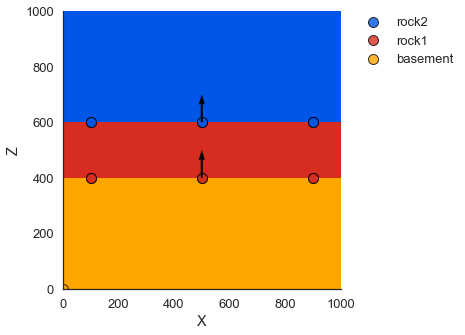

In [9]:
%matplotlib inline
gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=True, cmap=cmap, norm=None)

plt.savefig(fname='Model1_pure', edgecolor='black')

In [10]:
import gempy.utils.Kriging_Jan as krige

In [11]:
d = {'X': [500, 500], 'Y': [10, 10], 'Z': [500,500], 'Property': [20, 20]}
data_field = pd.DataFrame(data=d)
print(data_field)

     X   Y    Z  Property
0  500  10  500        20
1  500  10  500        20


In [12]:
np.random.seed(13124)

In [13]:
test = krige.Kriging(data_field, lith_block, geo_data, formation_number=2, kriging_type='OK', distance_type='euclidian', an_factor=1, var_par=(200,50,1))

initializing: 0.013797521591186523
distance precalculation: 0.22382330894470215
4000
submatrix extraction: 0.003038167953491211
distance Matrices: 0.3280017375946045
kriging calculation: 0.47312092781066895
Negative Variances: 0
Out of: 4001


In [14]:
coord = test.result_coord[:3]
result = test.kriging_result[1]
combined = np.vstack((coord, result))
combined = np.swapaxes(combined,0,1)

combined_cut = np.where(combined[:,1]<10)[0]
combined_cut = combined[combined_cut]
combined_cut = combined_cut[:,[0,2,3]]

In [15]:
colormodel = {'basement':'#696969','rock1':'#A0A0A0','rock2':'#BEBEBE','rock3':'#008744','fault':'#17202a'}
geo_data.set_colors(colormodel)
cmap = matplotlib.colors.ListedColormap(list(geo_data.formations['color']))

In [16]:
from numpy import linspace, meshgrid
from matplotlib.mlab import griddata

def grid(x, y, z, resX=100, resY=100):
    "Convert 3 column data to matplotlib grid"
    xi = linspace(min(x), max(x), resX)
    yi = linspace(min(y), max(y), resY)
    Z = griddata(x, y, z, xi, yi, interp='linear')
    X, Y = meshgrid(xi, yi)
    return X, Y, Z

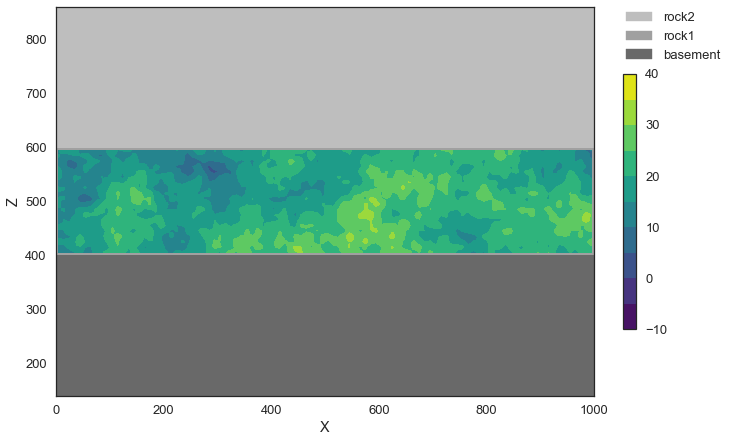

In [17]:
X, Y, Z = grid(combined_cut[:,0], combined_cut[:,1], combined_cut[:,2])

norm=matplotlib.colors.Normalize(vmin=-10, vmax=40)
v = np.linspace(-10, 40,11, endpoint=True)

a = plt.contourf(X, Y, Z, v, cmap='viridis', norm=norm)

gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=False, cmap=cmap, norm=None)

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(200,800)

plt.colorbar(a, orientation='vertical', fraction=0.022, pad=0.05)

plt.savefig(fname='Basic_SGS_truth', edgecolor='black', bbox_inches='tight')
#fig.tight_layout()

In [18]:
# Sampling
def random_sampling(data):
    #print(len(data))
    rand_pos = np.random.randint(0,len(data),50)
    #print(rand_pos)
    #print(rand_pos.shape)
    samples = data[rand_pos]
    return samples

In [19]:
samples = random_sampling(combined)

In [20]:
d = {'X': samples[:,0], 'Y': samples[:,1], 'Z': samples[:,2], 'Property': samples[:,3]}
data_field_sampled = pd.DataFrame(data=d)
#print(data_field)

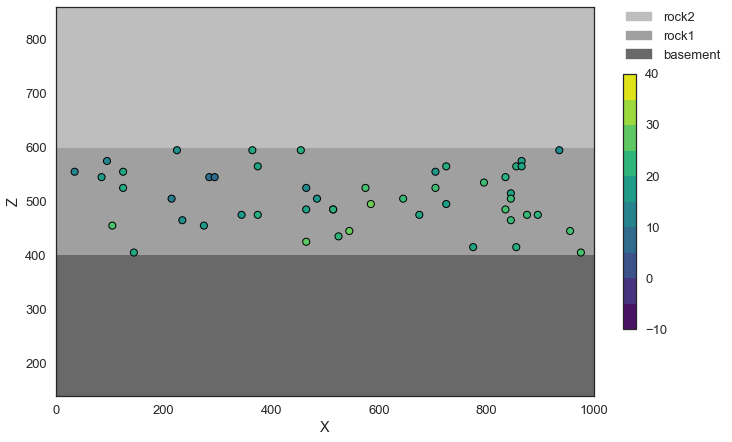

In [21]:
gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=False, cmap=cmap, norm=None)

plt.scatter(x=samples[:,0], y=samples[:,2], c=samples[:,3], s=50, cmap='viridis', linewidths=1, edgecolors='black', norm=norm)

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(200,800)

plt.colorbar(a, orientation='vertical', fraction=0.022, pad=0.05)

plt.savefig(fname='Basic_sampling', edgecolor='black', bbox_inches='tight')

In [45]:
np.random.seed(1312434)

In [46]:
simulation = krige.Kriging(data_field_sampled, lith_block, geo_data, formation_number=2, kriging_type='SK', distance_type='euclidian', var_par=(200,50,1))

initializing: 0.013311147689819336
distance precalculation: 0.24542546272277832
4000
submatrix extraction: 0.016427040100097656
distance Matrices: 0.35938239097595215
kriging calculation: 0.4207611083984375
Negative Variances: 0
Out of: 4000


In [47]:
coord = simulation.result_coord[:3]
result = simulation.kriging_result[1]
combined = np.vstack((coord, result))
combined = np.swapaxes(combined,0,1)

combined_cut = np.where(combined[:,1]<10)[0]
combined_cut = combined[combined_cut]
combined_cut = combined_cut[:,[0,2,3]]

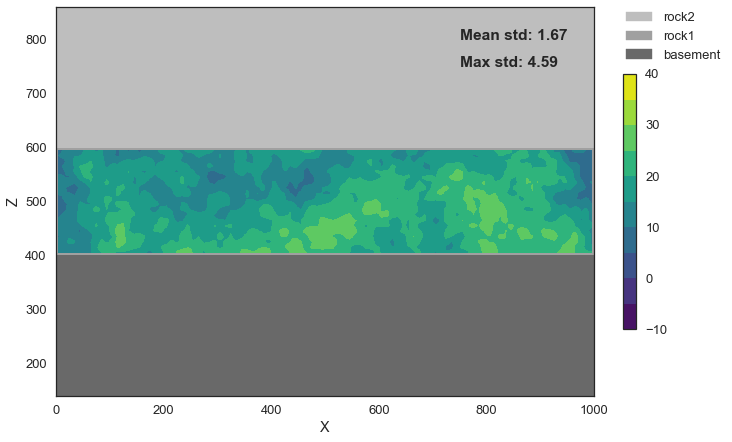

In [48]:
X, Y, Z = grid(combined_cut[:,0], combined_cut[:,1], combined_cut[:,2])

norm=matplotlib.colors.Normalize(vmin=-10, vmax=40)
v = np.linspace(-10, 40,11, endpoint=True)

a = plt.contourf(X, Y, Z, v, cmap='viridis', norm=norm)

gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=False, cmap=cmap, norm=None)

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(200,800)
plt.text(750,800,'Mean std: %s'%np.round(np.mean(simulation.std[:len(simulation.std)-49]),2), fontweight='bold')
plt.text(750,750,'Max std: %s'%np.round(np.max(simulation.std[:len(simulation.std)-49]),2), fontweight='bold')

plt.colorbar(a, orientation='vertical', fraction=0.022, pad=0.05)

plt.savefig(fname='Example_SGS_SK_200_50_1_mean=0', edgecolor='black', bbox_inches='tight')
#fig.tight_layout()

In [55]:
np.random.seed(1312434)

In [56]:
simulation = krige.Kriging(data_field_sampled, lith_block, geo_data, formation_number=2, kriging_type='OK', distance_type='euclidian', var_par=(50,50,1))

initializing: 0.013271808624267578
distance precalculation: 0.20072269439697266
4000
submatrix extraction: 0.009554147720336914
distance Matrices: 0.23539304733276367
kriging calculation: 0.5534071922302246
Negative Variances: 0
Out of: 4000


In [57]:
#print(simulation.std[:len(simulation.std)-49])

In [85]:
import scipy.optimize as opt

(1, 3.5)

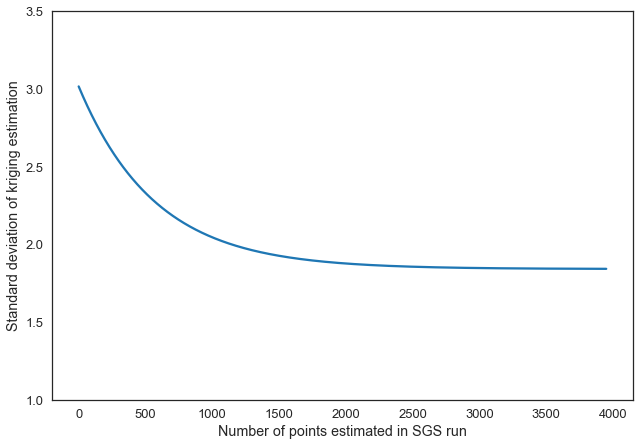

In [93]:

#plt.scatter(np.arange(0,len(simulation.std)-49,1), simulation.std[:len(simulation.std)-49], zorder=-1)

def func(x, a, b, c):
     return a * np.exp(-b * x) + c
    
optimizedParameters, pcov = opt.curve_fit(func, np.arange(0,len(simulation.std)-49,1), simulation.std[:len(simulation.std)-49])
plt.plot(np.arange(0,len(simulation.std)-49,1), func(np.arange(0,len(simulation.std)-49,1), *optimizedParameters), label="fit")

plt.ylabel('Standard deviation of kriging estimation')
plt.xlabel('Number of points estimated in SGS run')
plt.ylim((1,3.5))

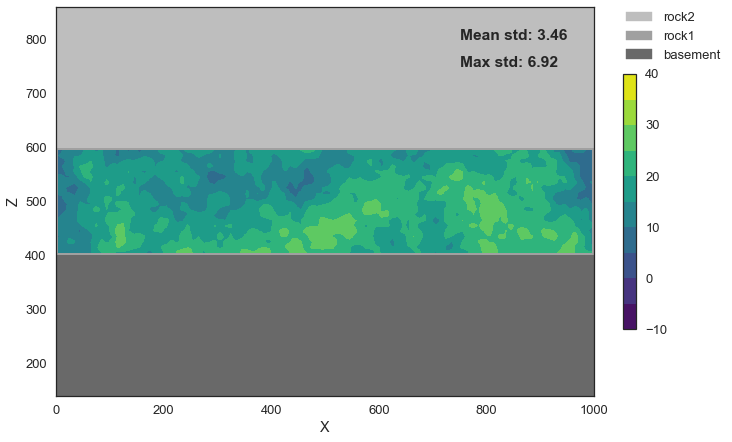

In [59]:
X, Y, Z = grid(combined_cut[:,0], combined_cut[:,1], combined_cut[:,2])

norm=matplotlib.colors.Normalize(vmin=-10, vmax=40)
v = np.linspace(0-10, 40,11, endpoint=True)

a = plt.contourf(X, Y, Z, v, cmap='viridis', norm=norm)

gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=False, cmap=cmap, norm=None)

plt.text(750,800,'Mean std: %s'%np.round(np.mean(simulation.std[:len(simulation.std)-49]),2), fontweight='bold')
plt.text(750,750,'Max std: %s'%np.round(np.max(simulation.std[:len(simulation.std)-49]),2), fontweight='bold')

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(200,800)

plt.colorbar(a, orientation='vertical', fraction=0.022, pad=0.05)

plt.savefig(fname='Example_SGS_OK_50_50_1', edgecolor='black', bbox_inches='tight')
#fig.tight_layout()

# UK preparation

In [60]:
data_field_sampled_UK = data_field_sampled
#print(data_field_sampled)
x = data_field_sampled['X'].values
prop = data_field_sampled['Property'].values

In [61]:
def linear_trend(x):
    prop_res = np.zeros(len(x))
    prop_res[:]= 0.01*(x[:])+15
    return prop_res

def linear_trend_data(x, prop):
    prop_res = np.zeros(len(x))
    prop_res[:]= prop[:]+0.01*(x[:])-5
    return prop_res

In [62]:
new_prop=linear_trend_data(x, prop)
#print(new_prop)
data_field_sampled_UK['Property']=new_prop
#print(data_field_sampled_UK)

In [63]:
prop_trend = linear_trend(x)
print(prop_trend)

[23.75 17.85 22.75 23.45 20.75 23.65 19.85 23.35 15.95 22.05 24.35 19.55
 23.55 17.95 16.25 17.35 16.25 23.55 17.15 19.65 15.35 18.65 22.05 15.85
 21.75 22.25 23.35 20.15 16.05 18.75 24.75 17.75 20.45 16.45 22.95 20.25
 20.85 23.65 20.15 23.45 19.65 24.55 18.75 21.45 23.95 18.45 19.65 22.25
 23.45 17.25]


# UK

In [64]:
residuals = np.abs(new_prop - prop_trend)
print(residuals)

[ 3.78815057 11.72175393  0.62339914  3.82951792  5.1915244   1.61830829
  3.96020924  1.95710064  7.27679149  2.96102388  5.97491723  0.92579349
  0.59363301 12.67560737  0.27089787  5.1291395   0.74953015  1.09690327
  8.99220792  6.75498825  7.13328212  0.24457448  4.69509086  2.47338268
  0.86417815  1.94964438  5.11370534  2.44738166  5.53341251  1.75867769
  5.5184237   3.21766074  8.30198539  0.45226858  4.45829975  2.5377069
  8.89310193  0.69263341  1.93678651  1.26876178  7.32888316  5.01499036
  0.88386736  3.74200297  2.4003397   2.94247889  1.67725456  1.35019861
  3.6657001   4.95533017]


In [65]:
def exponential_variogram_model(self, d):
    psill = self.sill - self.nugget
    gamma = psill * (1. - np.exp(-(np.absolute(d) / (self.range_)))) + self.nugget
    return gamma

In [66]:
#print(data_field_sampled_UK[['X','Z']].values)

In [67]:
from scipy import spatial

In [68]:
pos = 0
h = np.empty((len(residuals), len(residuals)))
gamma = np.empty((len(residuals), len(residuals)))

data_m = data_field_sampled_UK[['X','Y','Z']].values
#print(data_m)
data_v = residuals


for pos in range (len(residuals)):
    for i in range (len(residuals)):
        gamma[pos, i] = ((data_v[i]-data_v[pos])**2)/2
        h[pos, i] = spatial.distance.euclidean(data_m[i], data_m[pos])

In [69]:
bins = 50
maxim = 1000
bin_size = maxim/bins
a = 0

h_bins = np.empty(bins)
ave_vals = np.empty(bins)

for j in range (bins):
    bi = np.where((h > a)*(h < (a+bin_size)))
    ave_vals[j] = np.average(gamma[bi])
    h_bins[j] = (a+a+bin_size)/2
    a += bin_size

C:\Users\Jan\Anaconda3\lib\site-packages\numpy\lib\function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)


No handles with labels found to put in legend.


(0, 24.697524176901915)

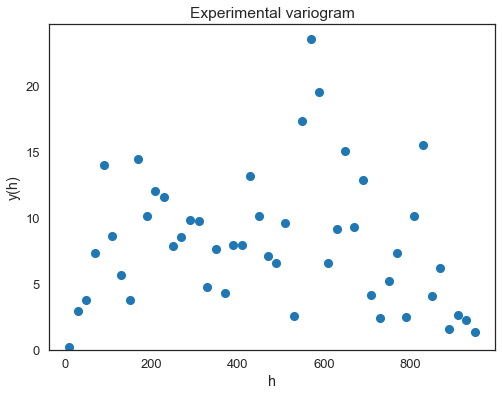

In [70]:
#plot figure
plt.figure(figsize=(8,6))
plt.plot(h_bins, ave_vals,'o')
plt.xlabel("h")
plt.ylabel("y(h)")
plt.title('Experimental variogram')
#plt.plot(h, experimental_variogram_model(h, gaussian_range, gaussian_sill),'-',label='Gaussian')
plt.legend(loc ='best')
plt.ylim(0)

In [73]:
np.random.seed(1312434)

In [74]:
simulation = krige.Kriging(data_field_sampled_UK, lith_block, geo_data, formation_number=2, kriging_type='UK', distance_type='euclidian', var_par=(100,10,1))

initializing: 0.011566162109375
distance precalculation: 0.2219536304473877
4000
submatrix extraction: 0.0
distance Matrices: 0.2873706817626953
kriging calculation: 0.6209604740142822
Negative Variances: 0
Out of: 4000


In [75]:
coord = simulation.result_coord[:3]
result = simulation.kriging_result[1]
combined = np.vstack((coord, result))
combined = np.swapaxes(combined,0,1)

combined_cut = np.where(combined[:,1]<10)[0]
combined_cut = combined[combined_cut]
combined_cut = combined_cut[:,[0,2,3]]

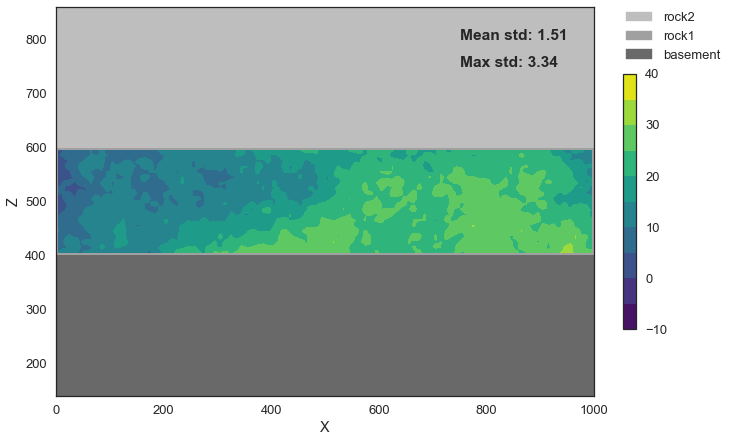

In [76]:
X, Y, Z = grid(combined_cut[:,0], combined_cut[:,1], combined_cut[:,2])

norm=matplotlib.colors.Normalize(vmin=-10, vmax=40)
v = np.linspace(-10, 40,11, endpoint=True)

a = plt.contourf(X, Y, Z, v, cmap='viridis', norm=norm)
#a = plt.contourf(X, Y, Z, cmap='viridis')

gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=False, cmap=cmap, norm=None)

plt.text(750,800,'Mean std: %s'%np.round(np.mean(simulation.std[:len(simulation.std)-49]),2), fontweight='bold')
plt.text(750,750,'Max std: %s'%np.round(np.max(simulation.std[:len(simulation.std)-49]),2), fontweight='bold')

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(200,800)

plt.colorbar(a, orientation='vertical', fraction=0.022, pad=0.05)

plt.savefig(fname='Example_SGS_ukdata_UK_100_10_1', edgecolor='black', bbox_inches='tight')
#fig.tight_layout()

In [79]:
np.random.seed(1312434)

In [80]:
simulation = krige.Kriging(data_field_sampled_UK, lith_block, geo_data, formation_number=2, kriging_type='OK', distance_type='euclidian', var_par=(200,50,1))

initializing: 0.0
distance precalculation: 0.19973063468933105
4000
submatrix extraction: 0.0055389404296875
distance Matrices: 0.23996829986572266
kriging calculation: 0.5399906635284424
Negative Variances: 0
Out of: 4000


In [81]:
coord = simulation.result_coord[:3]
result = simulation.kriging_result[1]
combined = np.vstack((coord, result))
combined = np.swapaxes(combined,0,1)

combined_cut = np.where(combined[:,1]<10)[0]
combined_cut = combined[combined_cut]
combined_cut = combined_cut[:,[0,2,3]]

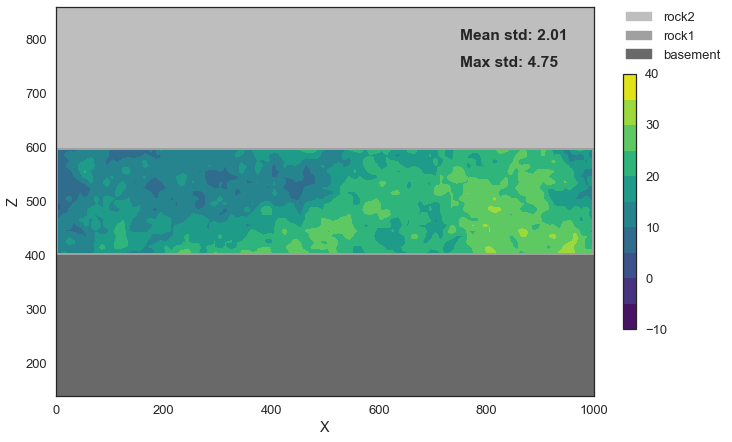

In [83]:
X, Y, Z = grid(combined_cut[:,0], combined_cut[:,1], combined_cut[:,2])

norm=matplotlib.colors.Normalize(vmin=-10, vmax=40)
v = np.linspace(-10, 40,11, endpoint=True)

a = plt.contourf(X, Y, Z, v, cmap='viridis', norm=norm)

gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=False, cmap=cmap, norm=None)

plt.text(750,800,'Mean std: %s'%np.round(np.mean(simulation.std[:len(simulation.std)-49]),2), fontweight='bold')
plt.text(750,750,'Max std: %s'%np.round(np.max(simulation.std[:len(simulation.std)-49]),2), fontweight='bold')

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(200,800)

plt.colorbar(a, orientation='vertical', fraction=0.022, pad=0.05)

plt.savefig(fname='Example_SGS_Ukdata_OK_200_50_1', edgecolor='black', bbox_inches='tight')
#fig.tight_layout()